In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [5]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
df = pd.read_csv("Tetuan City power consumption.csv")

In [7]:
from datetime import datetime

In [8]:
#Converting object to datetime datatype

df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') 

In [9]:
#transforming DateTime column into index
df = df.set_index('DateTime')

In [10]:
del df["Zone 2  Power Consumption"]


In [11]:
del df["Zone 3  Power Consumption"]

In [12]:
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452


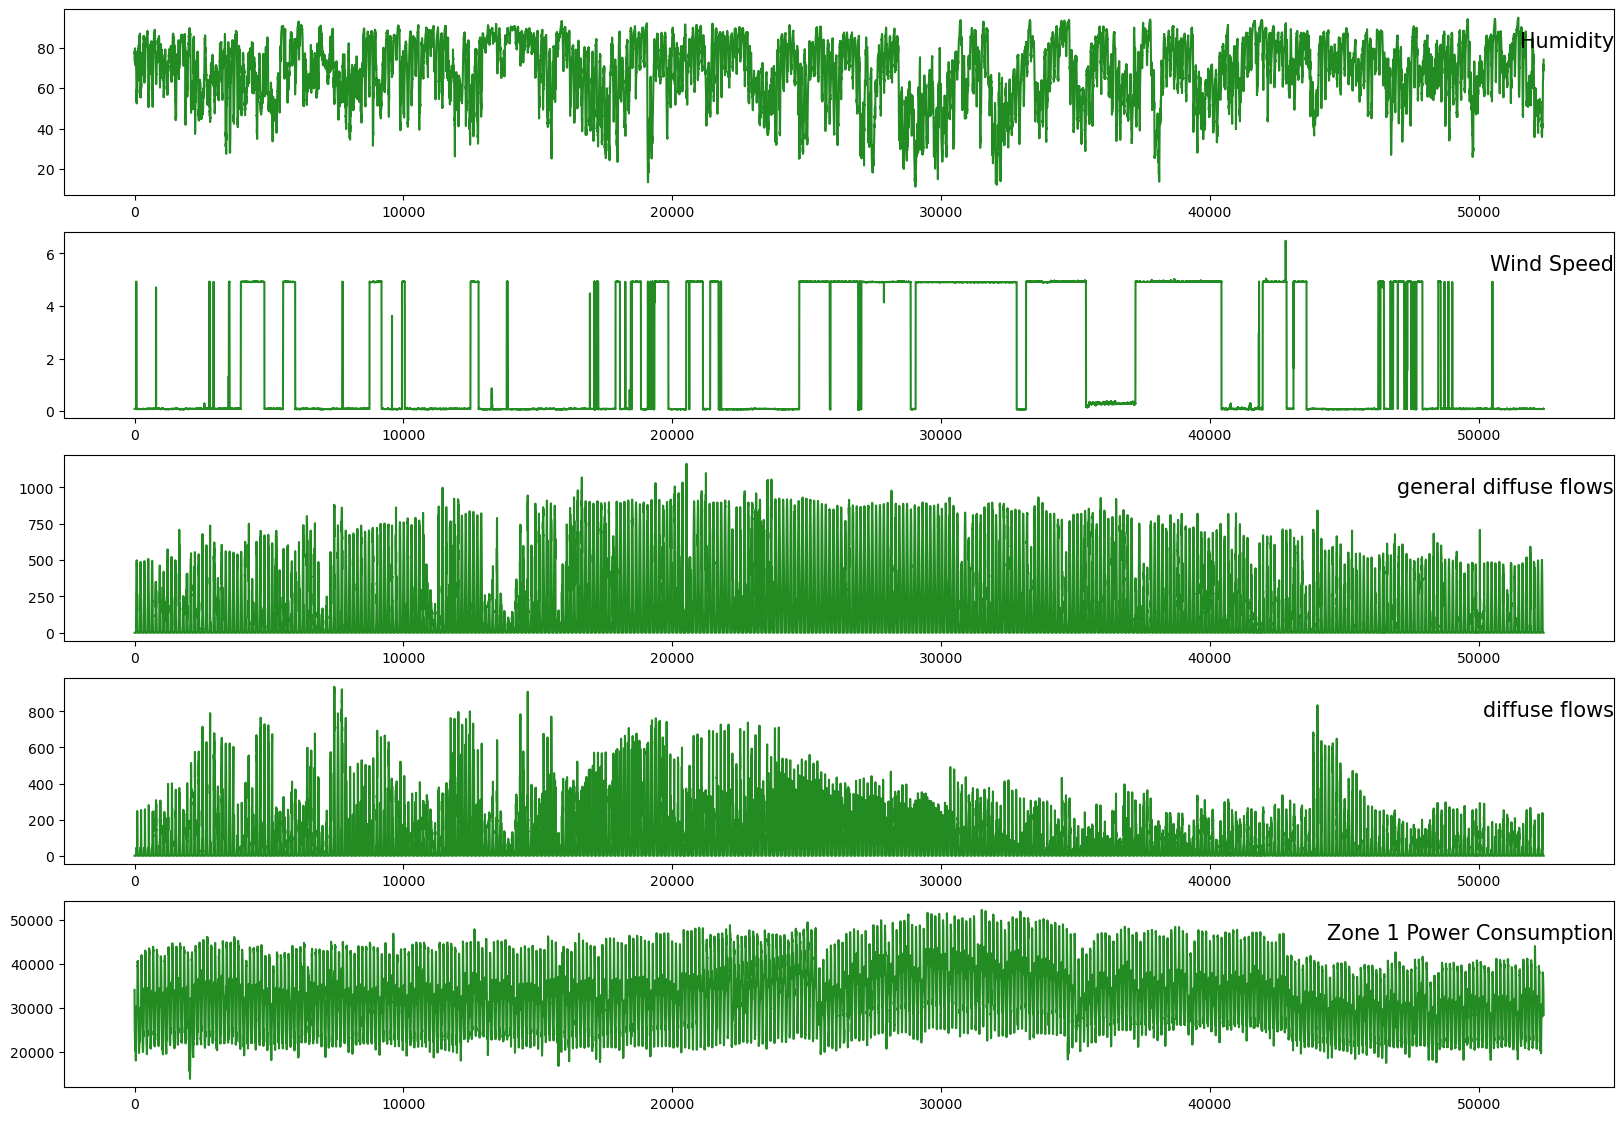

In [13]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

In [14]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(52415, 12)


In [16]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [17]:
len(reframed.columns)

12

In [18]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1   0.090091   0.748382   0.005130   0.000040   0.000115   0.526251  0.415545
2   0.086146   0.756770   0.005130   0.000057   0.000079   0.415545  0.397623
3   0.083399   0.756770   0.004663   0.000050   0.000095   0.397623  0.374149
4   0.078176   0.762761   0.005130   0.000075   0.000091   0.374149  0.350834
5   0.072736   0.771148   0.004819   0.000038   0.000079   0.350834  0.332277


### Splitting the training data given into training and testing data for now.

In [19]:
values = reframed.values

# chia theo phut trong nam 2017 va lay 80% de train 20% test
n_train_minutes = 41932

train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(41932, 1, 6) (41932,) (10483, 1, 6) (10483,)


# 3 lớp LSTM, VỚI MỘT LỚP DROPOUT

In [132]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 6s - loss: 0.0126 - val_loss: 4.8159e-04 - 6s/epoch - 6ms/step
Epoch 2/500
1119/1119 - 3s - loss: 0.0028 - val_loss: 3.5918e-04 - 3s/epoch - 3ms/step
Epoch 3/500
1119/1119 - 3s - loss: 0.0019 - val_loss: 4.6545e-04 - 3s/epoch - 3ms/step
Epoch 4/500
1119/1119 - 3s - loss: 0.0012 - val_loss: 5.0208e-04 - 3s/epoch - 3ms/step
Epoch 5/500
1119/1119 - 3s - loss: 9.4146e-04 - val_loss: 5.0112e-04 - 3s/epoch - 3ms/step
Epoch 6/500
1119/1119 - 3s - loss: 8.3231e-04 - val_loss: 3.2256e-04 - 3s/epoch - 3ms/step
Epoch 7/500
1119/1119 - 3s - loss: 8.4358e-04 - val_loss: 4.7022e-04 - 3s/epoch - 3ms/step
Epoch 8/500
1119/1119 - 3s - loss: 8.2768e-04 - val_loss: 3.8153e-04 - 3s/epoch - 3ms/step
Epoch 9/500
1119/1119 - 3s - loss: 8.1564e-04 - val_loss: 2.5862e-04 - 3s/epoch - 3ms/step
Epoch 10/500
1119/1119 - 3s - loss: 8.2323e-04 - val_loss: 3.1204e-04 - 3s/epoch - 3ms/step
Epoch 11/500
1119/1119 - 3s - loss: 8.3261e-04 - val_loss: 3.5699e-04 - 3s/epoch - 3ms/step
Epoch 12/500


Epoch 91/500
1119/1119 - 3s - loss: 7.3273e-04 - val_loss: 2.6499e-04 - 3s/epoch - 3ms/step
Epoch 92/500
1119/1119 - 3s - loss: 7.3047e-04 - val_loss: 2.1292e-04 - 3s/epoch - 3ms/step
Epoch 93/500
1119/1119 - 3s - loss: 7.3751e-04 - val_loss: 2.6021e-04 - 3s/epoch - 3ms/step
Epoch 94/500
1119/1119 - 3s - loss: 7.2918e-04 - val_loss: 1.7907e-04 - 3s/epoch - 3ms/step
Epoch 95/500
1119/1119 - 3s - loss: 7.2867e-04 - val_loss: 1.8338e-04 - 3s/epoch - 3ms/step
Epoch 96/500
1119/1119 - 3s - loss: 7.3398e-04 - val_loss: 2.1500e-04 - 3s/epoch - 3ms/step
Epoch 97/500
1119/1119 - 3s - loss: 7.4091e-04 - val_loss: 2.1880e-04 - 3s/epoch - 3ms/step
Epoch 98/500
1119/1119 - 3s - loss: 7.2240e-04 - val_loss: 2.5943e-04 - 3s/epoch - 3ms/step
Epoch 99/500
1119/1119 - 3s - loss: 7.3211e-04 - val_loss: 1.8077e-04 - 3s/epoch - 3ms/step
Epoch 100/500
1119/1119 - 3s - loss: 7.2409e-04 - val_loss: 2.2748e-04 - 3s/epoch - 3ms/step
Epoch 101/500
1119/1119 - 3s - loss: 7.2915e-04 - val_loss: 2.6091e-04 - 3s/epo

Epoch 180/500
1119/1119 - 3s - loss: 7.1291e-04 - val_loss: 2.1632e-04 - 3s/epoch - 3ms/step
Epoch 181/500
1119/1119 - 3s - loss: 7.1788e-04 - val_loss: 2.1381e-04 - 3s/epoch - 3ms/step
Epoch 182/500
1119/1119 - 3s - loss: 7.2516e-04 - val_loss: 2.3014e-04 - 3s/epoch - 3ms/step
Epoch 183/500
1119/1119 - 3s - loss: 7.1520e-04 - val_loss: 2.6738e-04 - 3s/epoch - 3ms/step
Epoch 184/500
1119/1119 - 3s - loss: 7.2261e-04 - val_loss: 1.9897e-04 - 3s/epoch - 3ms/step
Epoch 185/500
1119/1119 - 3s - loss: 7.1273e-04 - val_loss: 2.0140e-04 - 3s/epoch - 3ms/step
Epoch 186/500
1119/1119 - 3s - loss: 7.1688e-04 - val_loss: 1.7829e-04 - 3s/epoch - 3ms/step
Epoch 187/500
1119/1119 - 3s - loss: 7.1642e-04 - val_loss: 2.0417e-04 - 3s/epoch - 3ms/step
Epoch 188/500
1119/1119 - 3s - loss: 7.0748e-04 - val_loss: 2.1533e-04 - 3s/epoch - 3ms/step
Epoch 189/500
1119/1119 - 3s - loss: 7.2372e-04 - val_loss: 1.9589e-04 - 3s/epoch - 3ms/step
Epoch 190/500
1119/1119 - 3s - loss: 7.2381e-04 - val_loss: 1.7220e-04

1119/1119 - 3s - loss: 6.9104e-04 - val_loss: 1.9858e-04 - 3s/epoch - 3ms/step
Epoch 269/500
1119/1119 - 3s - loss: 7.0265e-04 - val_loss: 1.8507e-04 - 3s/epoch - 3ms/step
Epoch 270/500
1119/1119 - 3s - loss: 7.0413e-04 - val_loss: 2.2914e-04 - 3s/epoch - 3ms/step
Epoch 271/500
1119/1119 - 3s - loss: 6.9222e-04 - val_loss: 2.9957e-04 - 3s/epoch - 3ms/step
Epoch 272/500
1119/1119 - 3s - loss: 7.1390e-04 - val_loss: 2.1668e-04 - 3s/epoch - 3ms/step
Epoch 273/500
1119/1119 - 3s - loss: 7.1354e-04 - val_loss: 2.9570e-04 - 3s/epoch - 3ms/step
Epoch 274/500
1119/1119 - 3s - loss: 7.0425e-04 - val_loss: 1.9940e-04 - 3s/epoch - 3ms/step
Epoch 275/500
1119/1119 - 3s - loss: 7.0462e-04 - val_loss: 1.8569e-04 - 3s/epoch - 3ms/step
Epoch 276/500
1119/1119 - 3s - loss: 7.1034e-04 - val_loss: 2.6146e-04 - 3s/epoch - 3ms/step
Epoch 277/500
1119/1119 - 3s - loss: 7.0341e-04 - val_loss: 2.0630e-04 - 3s/epoch - 3ms/step
Epoch 278/500
1119/1119 - 3s - loss: 6.8862e-04 - val_loss: 2.2337e-04 - 3s/epoch - 

Epoch 357/500
1119/1119 - 3s - loss: 6.9163e-04 - val_loss: 2.1879e-04 - 3s/epoch - 3ms/step
Epoch 358/500
1119/1119 - 3s - loss: 6.9538e-04 - val_loss: 2.1246e-04 - 3s/epoch - 3ms/step
Epoch 359/500
1119/1119 - 3s - loss: 7.0172e-04 - val_loss: 1.9482e-04 - 3s/epoch - 3ms/step
Epoch 360/500
1119/1119 - 3s - loss: 6.8920e-04 - val_loss: 1.9815e-04 - 3s/epoch - 3ms/step
Epoch 361/500
1119/1119 - 3s - loss: 6.9109e-04 - val_loss: 1.8817e-04 - 3s/epoch - 3ms/step
Epoch 362/500
1119/1119 - 3s - loss: 6.9362e-04 - val_loss: 2.9087e-04 - 3s/epoch - 3ms/step
Epoch 363/500
1119/1119 - 3s - loss: 6.8581e-04 - val_loss: 2.4088e-04 - 3s/epoch - 3ms/step
Epoch 364/500
1119/1119 - 3s - loss: 6.8680e-04 - val_loss: 2.0187e-04 - 3s/epoch - 3ms/step
Epoch 365/500
1119/1119 - 3s - loss: 6.9521e-04 - val_loss: 2.4723e-04 - 3s/epoch - 3ms/step
Epoch 366/500
1119/1119 - 3s - loss: 6.9283e-04 - val_loss: 2.2396e-04 - 3s/epoch - 3ms/step
Epoch 367/500
1119/1119 - 3s - loss: 7.0193e-04 - val_loss: 2.1412e-04

1119/1119 - 3s - loss: 6.8224e-04 - val_loss: 2.4602e-04 - 3s/epoch - 3ms/step
Epoch 446/500
1119/1119 - 3s - loss: 6.9357e-04 - val_loss: 2.8819e-04 - 3s/epoch - 3ms/step
Epoch 447/500
1119/1119 - 3s - loss: 6.8981e-04 - val_loss: 2.4661e-04 - 3s/epoch - 3ms/step
Epoch 448/500
1119/1119 - 3s - loss: 6.9469e-04 - val_loss: 1.8076e-04 - 3s/epoch - 3ms/step
Epoch 449/500
1119/1119 - 3s - loss: 6.8683e-04 - val_loss: 2.5211e-04 - 3s/epoch - 3ms/step
Epoch 450/500
1119/1119 - 3s - loss: 7.0489e-04 - val_loss: 1.8749e-04 - 3s/epoch - 3ms/step
Epoch 451/500
1119/1119 - 3s - loss: 6.8786e-04 - val_loss: 2.3697e-04 - 3s/epoch - 3ms/step
Epoch 452/500
1119/1119 - 3s - loss: 6.7847e-04 - val_loss: 2.2502e-04 - 3s/epoch - 3ms/step
Epoch 453/500
1119/1119 - 3s - loss: 6.8447e-04 - val_loss: 2.6173e-04 - 3s/epoch - 3ms/step
Epoch 454/500
1119/1119 - 3s - loss: 6.9271e-04 - val_loss: 3.1079e-04 - 3s/epoch - 3ms/step
Epoch 455/500
1119/1119 - 3s - loss: 6.9457e-04 - val_loss: 3.3740e-04 - 3s/epoch - 

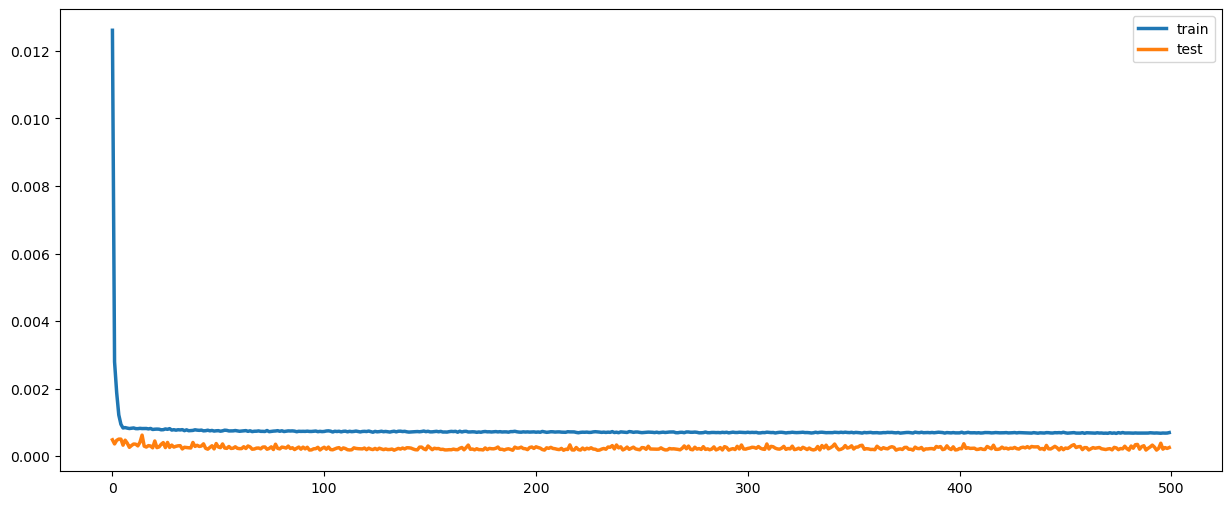

In [133]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [134]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 971us/step


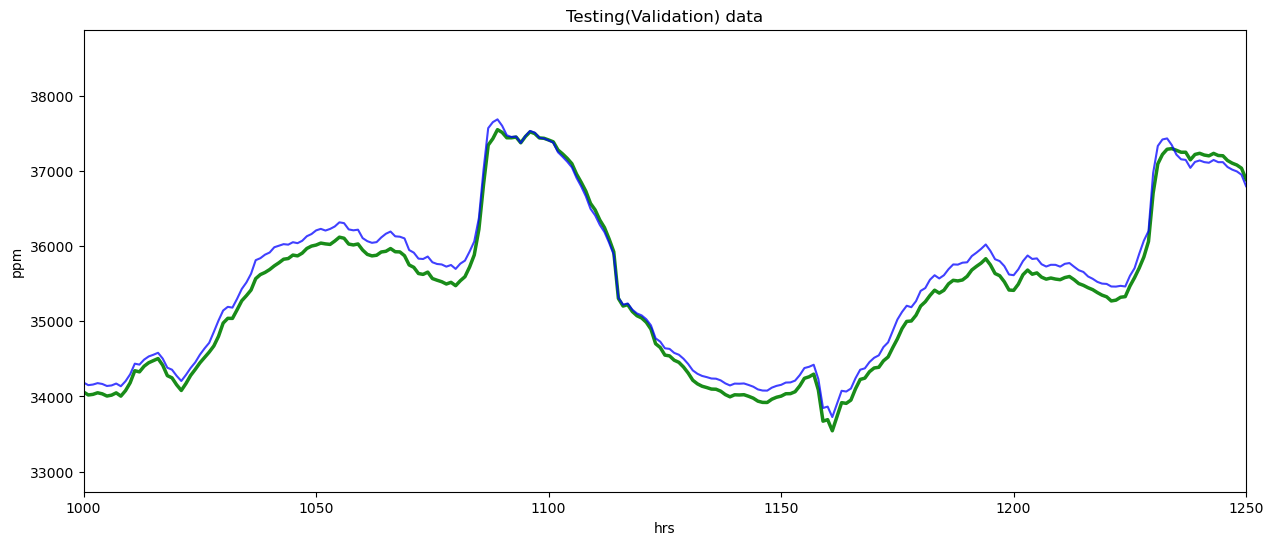

In [135]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [136]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 178.31071
MAPE: 0.4416842944920063 %


## Vẫn vị trí dropout nhưng epochs =  100

In [137]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 6s - loss: 0.0130 - val_loss: 6.1793e-04 - 6s/epoch - 5ms/step
Epoch 2/100
1119/1119 - 3s - loss: 0.0029 - val_loss: 7.3998e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1119/1119 - 3s - loss: 0.0018 - val_loss: 4.3340e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1119/1119 - 3s - loss: 0.0012 - val_loss: 4.0196e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1119/1119 - 3s - loss: 8.8994e-04 - val_loss: 3.5707e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1119/1119 - 3s - loss: 8.5348e-04 - val_loss: 3.1272e-04 - 3s/epoch - 3ms/step
Epoch 7/100
1119/1119 - 3s - loss: 8.1207e-04 - val_loss: 2.7500e-04 - 3s/epoch - 3ms/step
Epoch 8/100
1119/1119 - 3s - loss: 8.1484e-04 - val_loss: 3.0811e-04 - 3s/epoch - 3ms/step
Epoch 9/100
1119/1119 - 3s - loss: 8.1263e-04 - val_loss: 2.9678e-04 - 3s/epoch - 3ms/step
Epoch 10/100
1119/1119 - 3s - loss: 8.3560e-04 - val_loss: 3.8941e-04 - 3s/epoch - 3ms/step
Epoch 11/100
1119/1119 - 3s - loss: 8.2440e-04 - val_loss: 2.8477e-04 - 3s/epoch - 3ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 3s - loss: 7.3158e-04 - val_loss: 2.1492e-04 - 3s/epoch - 3ms/step
Epoch 92/100
1119/1119 - 3s - loss: 7.3639e-04 - val_loss: 2.2783e-04 - 3s/epoch - 3ms/step
Epoch 93/100
1119/1119 - 3s - loss: 7.3151e-04 - val_loss: 2.0032e-04 - 3s/epoch - 3ms/step
Epoch 94/100
1119/1119 - 3s - loss: 7.3308e-04 - val_loss: 2.2263e-04 - 3s/epoch - 3ms/step
Epoch 95/100
1119/1119 - 3s - loss: 7.2775e-04 - val_loss: 2.1035e-04 - 3s/epoch - 3ms/step
Epoch 96/100
1119/1119 - 3s - loss: 7.2364e-04 - val_loss: 1.9377e-04 - 3s/epoch - 3ms/step
Epoch 97/100
1119/1119 - 3s - loss: 7.2255e-04 - val_loss: 2.0761e-04 - 3s/epoch - 3ms/step
Epoch 98/100
1119/1119 - 3s - loss: 7.1846e-04 - val_loss: 2.4073e-04 - 3s/epoch - 3ms/step
Epoch 99/100
1119/1119 - 3s - loss: 7.2337e-04 - val_loss: 2.4432e-04 - 3s/epoch - 3ms/step
Epoch 100/100
1119/1119 - 3s - loss: 7.2512e-04 - val_loss: 2.2328e-04 - 3s/epoch - 3ms/step


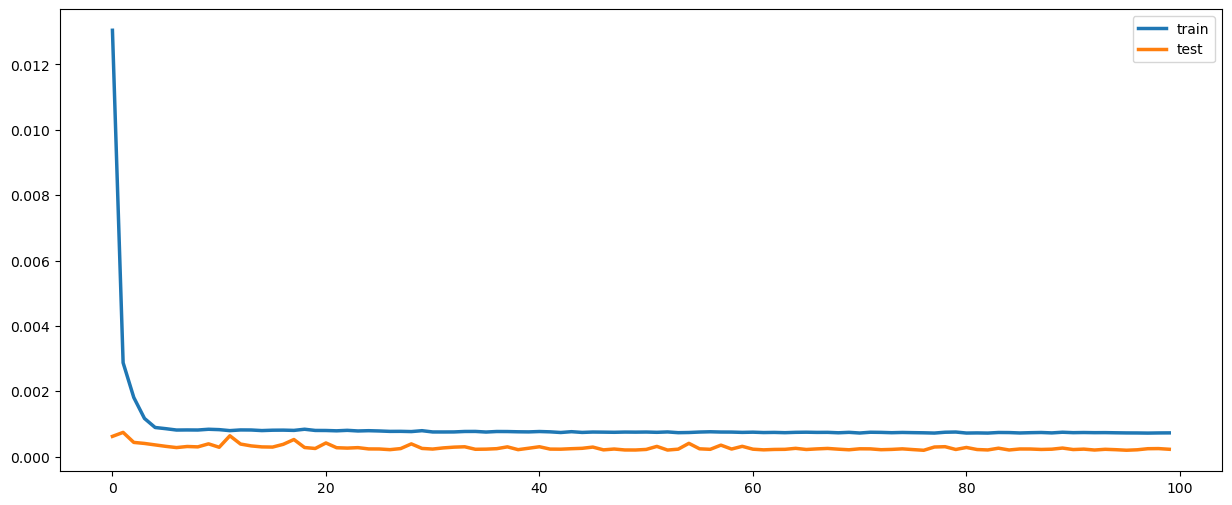

In [138]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [139]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 1ms/step


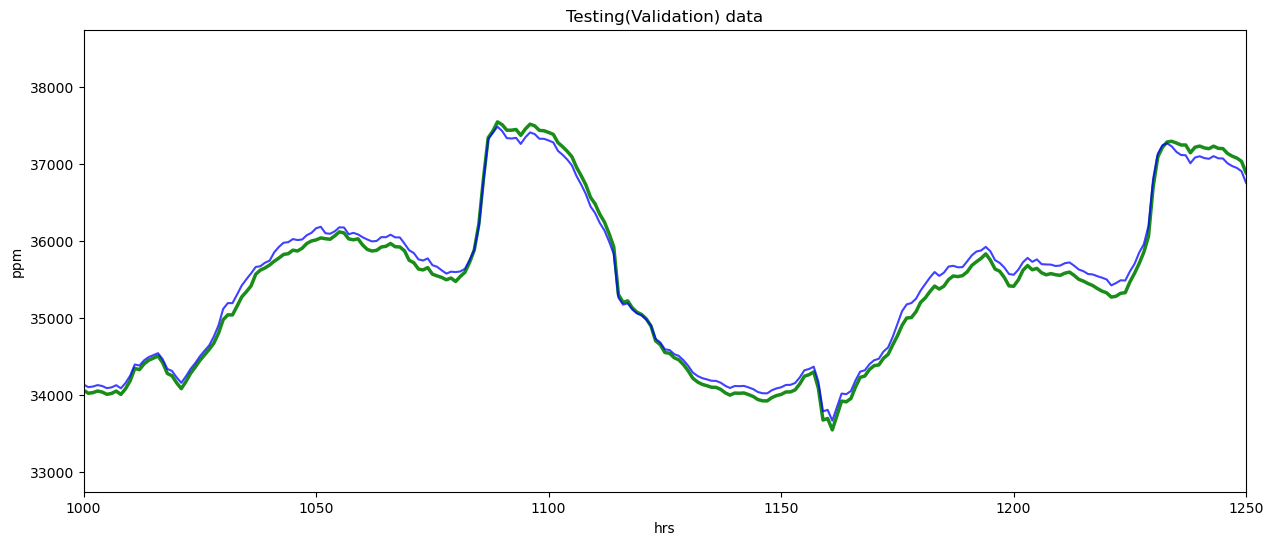

In [140]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [141]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 125.098015
MAPE: 0.3172813914716244 %


## Vẫn vị trí dropout nhưng epochs = 50

In [142]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 6s - loss: 0.0130 - val_loss: 8.7683e-04 - 6s/epoch - 5ms/step
Epoch 2/100
1119/1119 - 3s - loss: 0.0029 - val_loss: 3.7196e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1119/1119 - 3s - loss: 0.0019 - val_loss: 3.7110e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1119/1119 - 3s - loss: 0.0012 - val_loss: 4.7867e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1119/1119 - 3s - loss: 9.4130e-04 - val_loss: 3.3231e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1119/1119 - 3s - loss: 8.3932e-04 - val_loss: 4.4228e-04 - 3s/epoch - 3ms/step
Epoch 7/100
1119/1119 - 3s - loss: 8.3945e-04 - val_loss: 3.3276e-04 - 3s/epoch - 3ms/step
Epoch 8/100
1119/1119 - 3s - loss: 8.1554e-04 - val_loss: 2.6290e-04 - 3s/epoch - 3ms/step
Epoch 9/100
1119/1119 - 3s - loss: 8.1721e-04 - val_loss: 3.0505e-04 - 3s/epoch - 3ms/step
Epoch 10/100
1119/1119 - 3s - loss: 8.4447e-04 - val_loss: 2.4989e-04 - 3s/epoch - 3ms/step
Epoch 11/100
1119/1119 - 3s - loss: 8.0007e-04 - val_loss: 2.9236e-04 - 3s/epoch - 3ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 3s - loss: 7.3793e-04 - val_loss: 2.0969e-04 - 3s/epoch - 3ms/step
Epoch 92/100
1119/1119 - 3s - loss: 7.3776e-04 - val_loss: 2.0540e-04 - 3s/epoch - 3ms/step
Epoch 93/100
1119/1119 - 3s - loss: 7.1970e-04 - val_loss: 2.4519e-04 - 3s/epoch - 3ms/step
Epoch 94/100
1119/1119 - 3s - loss: 7.3578e-04 - val_loss: 1.9364e-04 - 3s/epoch - 3ms/step
Epoch 95/100
1119/1119 - 3s - loss: 7.2910e-04 - val_loss: 2.1798e-04 - 3s/epoch - 3ms/step
Epoch 96/100
1119/1119 - 3s - loss: 7.2994e-04 - val_loss: 2.0084e-04 - 3s/epoch - 3ms/step
Epoch 97/100
1119/1119 - 3s - loss: 7.3442e-04 - val_loss: 2.5391e-04 - 3s/epoch - 3ms/step
Epoch 98/100
1119/1119 - 3s - loss: 7.4084e-04 - val_loss: 2.1823e-04 - 3s/epoch - 3ms/step
Epoch 99/100
1119/1119 - 3s - loss: 7.3034e-04 - val_loss: 2.4651e-04 - 3s/epoch - 3ms/step
Epoch 100/100
1119/1119 - 3s - loss: 7.2860e-04 - val_loss: 2.8363e-04 - 3s/epoch - 3ms/step


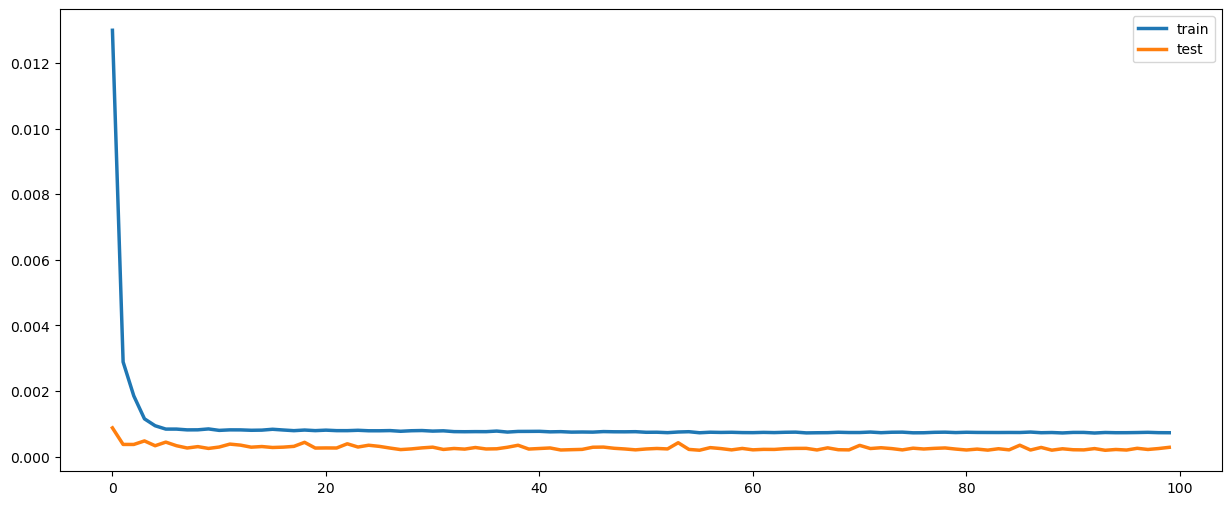

In [143]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [144]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 1ms/step


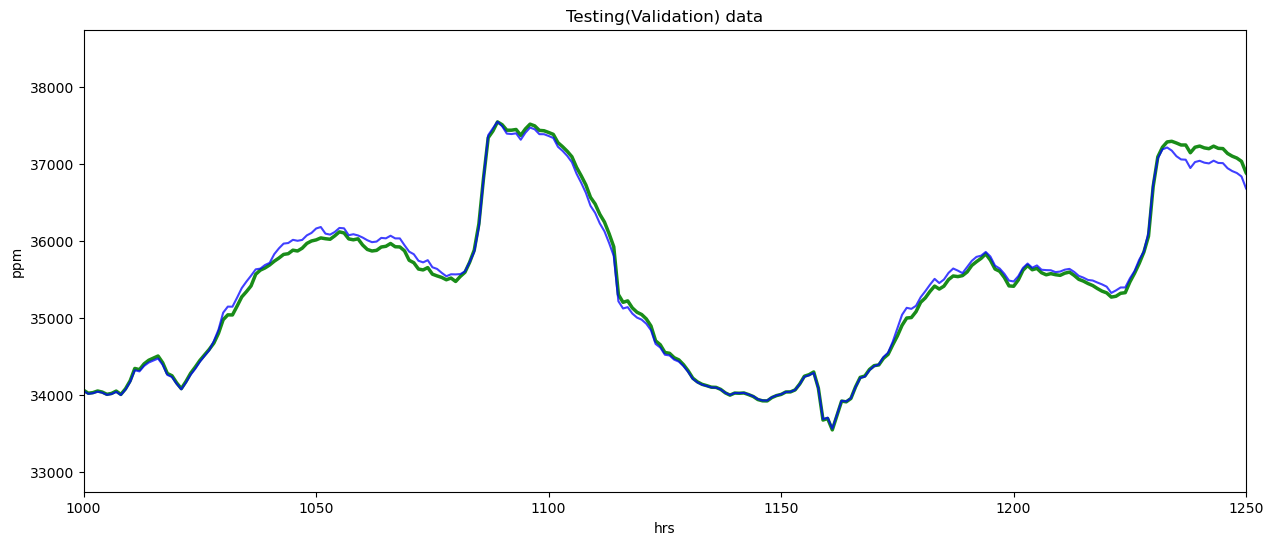

In [145]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [146]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 96.25525
MAPE: 0.20641274750232697 %


## Vẫn vị trí dropout nhưng epochs = 150

In [147]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 6s - loss: 0.0127 - val_loss: 5.6979e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1119/1119 - 3s - loss: 0.0029 - val_loss: 7.7040e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1119/1119 - 3s - loss: 0.0018 - val_loss: 5.0994e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1119/1119 - 3s - loss: 0.0012 - val_loss: 4.4606e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1119/1119 - 3s - loss: 9.2290e-04 - val_loss: 3.4314e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1119/1119 - 3s - loss: 8.4927e-04 - val_loss: 5.4855e-04 - 3s/epoch - 3ms/step
Epoch 7/100
1119/1119 - 3s - loss: 8.1975e-04 - val_loss: 4.1134e-04 - 3s/epoch - 3ms/step
Epoch 8/100
1119/1119 - 3s - loss: 8.1391e-04 - val_loss: 3.4375e-04 - 3s/epoch - 3ms/step
Epoch 9/100
1119/1119 - 3s - loss: 8.5082e-04 - val_loss: 4.7361e-04 - 3s/epoch - 3ms/step
Epoch 10/100
1119/1119 - 3s - loss: 8.0905e-04 - val_loss: 2.4847e-04 - 3s/epoch - 3ms/step
Epoch 11/100
1119/1119 - 3s - loss: 7.9775e-04 - val_loss: 2.6613e-04 - 3s/epoch - 3ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 3s - loss: 7.2185e-04 - val_loss: 2.2454e-04 - 3s/epoch - 3ms/step
Epoch 92/100
1119/1119 - 3s - loss: 7.2555e-04 - val_loss: 2.1929e-04 - 3s/epoch - 3ms/step
Epoch 93/100
1119/1119 - 3s - loss: 7.4343e-04 - val_loss: 2.6819e-04 - 3s/epoch - 3ms/step
Epoch 94/100
1119/1119 - 3s - loss: 7.3436e-04 - val_loss: 2.3219e-04 - 3s/epoch - 3ms/step
Epoch 95/100
1119/1119 - 3s - loss: 7.3361e-04 - val_loss: 2.2393e-04 - 3s/epoch - 3ms/step
Epoch 96/100
1119/1119 - 3s - loss: 7.5373e-04 - val_loss: 2.0898e-04 - 3s/epoch - 3ms/step
Epoch 97/100
1119/1119 - 3s - loss: 7.3037e-04 - val_loss: 2.3342e-04 - 3s/epoch - 3ms/step
Epoch 98/100
1119/1119 - 3s - loss: 7.3762e-04 - val_loss: 2.2718e-04 - 3s/epoch - 3ms/step
Epoch 99/100
1119/1119 - 3s - loss: 7.4016e-04 - val_loss: 1.9703e-04 - 3s/epoch - 3ms/step
Epoch 100/100
1119/1119 - 3s - loss: 7.3033e-04 - val_loss: 2.3627e-04 - 3s/epoch - 3ms/step


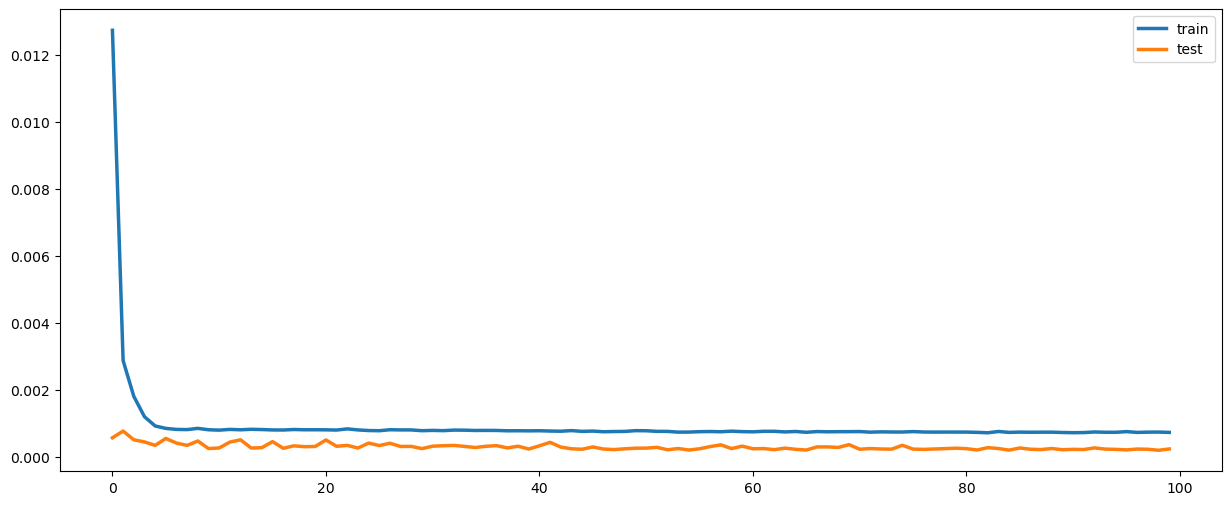

In [148]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [149]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 960us/step


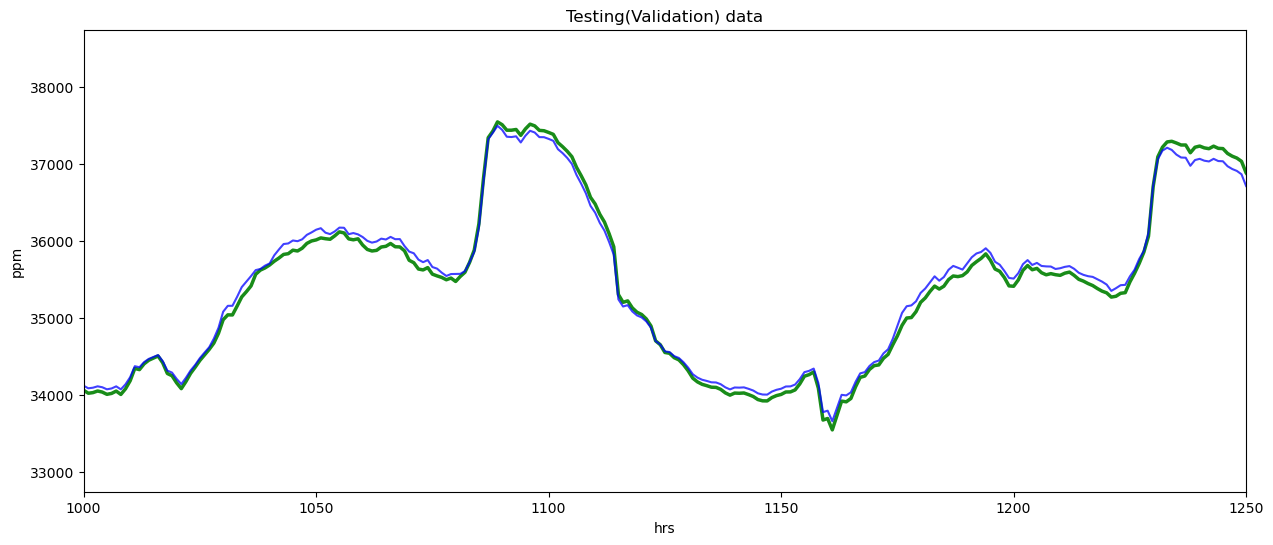

In [150]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [151]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 112.863846
MAPE: 0.28269016183912754 %


# Di chuyển vị trí dropout và epochs = 50


In [152]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
1119/1119 - 7s - loss: 0.0108 - val_loss: 6.2922e-04 - 7s/epoch - 6ms/step
Epoch 2/50
1119/1119 - 3s - loss: 0.0013 - val_loss: 7.3413e-04 - 3s/epoch - 3ms/step
Epoch 3/50
1119/1119 - 3s - loss: 9.6169e-04 - val_loss: 5.9640e-04 - 3s/epoch - 3ms/step
Epoch 4/50
1119/1119 - 3s - loss: 8.0451e-04 - val_loss: 4.1457e-04 - 3s/epoch - 3ms/step
Epoch 5/50
1119/1119 - 3s - loss: 6.9958e-04 - val_loss: 3.6208e-04 - 3s/epoch - 3ms/step
Epoch 6/50
1119/1119 - 3s - loss: 6.5487e-04 - val_loss: 3.4173e-04 - 3s/epoch - 3ms/step
Epoch 7/50
1119/1119 - 3s - loss: 6.0107e-04 - val_loss: 2.9125e-04 - 3s/epoch - 3ms/step
Epoch 8/50
1119/1119 - 3s - loss: 5.7070e-04 - val_loss: 3.2785e-04 - 3s/epoch - 3ms/step
Epoch 9/50
1119/1119 - 3s - loss: 5.5750e-04 - val_loss: 2.9158e-04 - 3s/epoch - 3ms/step
Epoch 10/50
1119/1119 - 3s - loss: 5.2680e-04 - val_loss: 2.6161e-04 - 3s/epoch - 3ms/step
Epoch 11/50
1119/1119 - 3s - loss: 5.3493e-04 - val_loss: 2.9117e-04 - 3s/epoch - 3ms/step
Epoch 12/50
1119

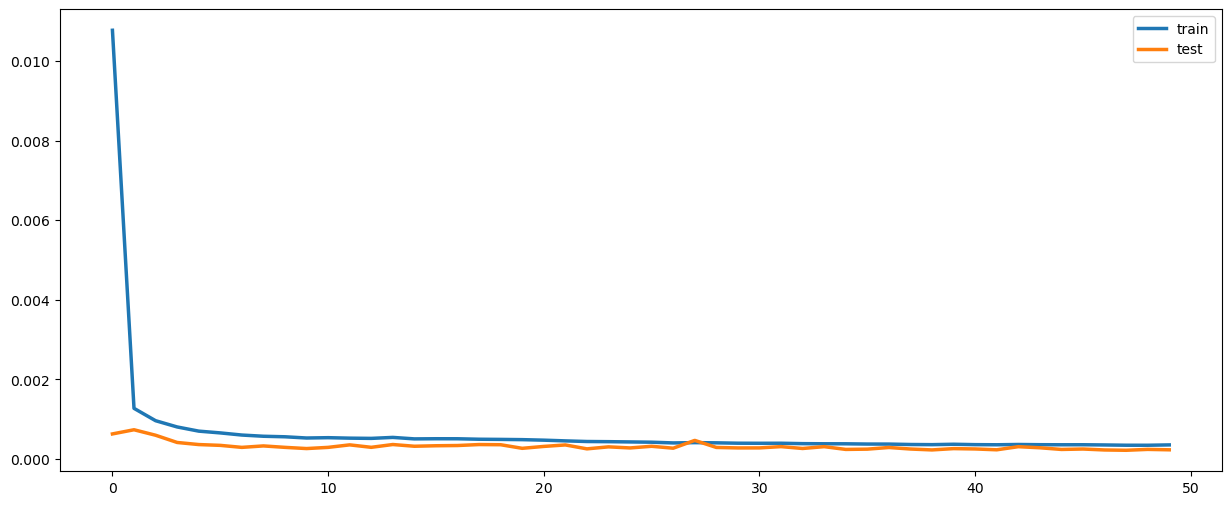

In [153]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [154]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 1ms/step


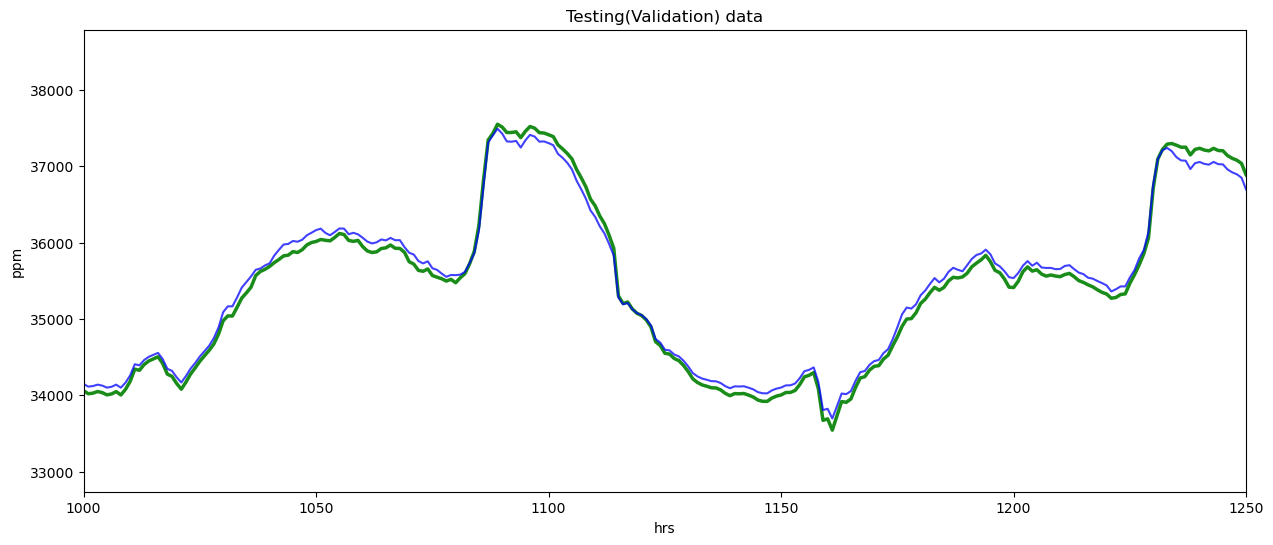

In [155]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [156]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 129.21005
MAPE: 0.3164032008498907 %


# Giữ vị trí dropout như trên và epochs = 100

In [157]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 6s - loss: 0.0110 - val_loss: 4.7018e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1119/1119 - 3s - loss: 0.0012 - val_loss: 5.4461e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1119/1119 - 3s - loss: 9.1492e-04 - val_loss: 5.1092e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1119/1119 - 3s - loss: 7.7899e-04 - val_loss: 4.0720e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1119/1119 - 3s - loss: 6.9851e-04 - val_loss: 3.8825e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1119/1119 - 3s - loss: 6.4958e-04 - val_loss: 5.0696e-04 - 3s/epoch - 3ms/step
Epoch 7/100
1119/1119 - 3s - loss: 5.9517e-04 - val_loss: 3.0600e-04 - 3s/epoch - 3ms/step
Epoch 8/100
1119/1119 - 3s - loss: 5.6092e-04 - val_loss: 3.6505e-04 - 3s/epoch - 3ms/step
Epoch 9/100
1119/1119 - 3s - loss: 5.5769e-04 - val_loss: 5.2309e-04 - 3s/epoch - 3ms/step
Epoch 10/100
1119/1119 - 3s - loss: 5.4239e-04 - val_loss: 3.7019e-04 - 3s/epoch - 3ms/step
Epoch 11/100
1119/1119 - 3s - loss: 5.3506e-04 - val_loss: 2.9677e-04 - 3s/epoch - 3ms/step
Epoch

Epoch 91/100
1119/1119 - 3s - loss: 3.1606e-04 - val_loss: 2.1607e-04 - 3s/epoch - 3ms/step
Epoch 92/100
1119/1119 - 3s - loss: 3.2065e-04 - val_loss: 2.0928e-04 - 3s/epoch - 3ms/step
Epoch 93/100
1119/1119 - 3s - loss: 3.1630e-04 - val_loss: 2.2392e-04 - 3s/epoch - 3ms/step
Epoch 94/100
1119/1119 - 3s - loss: 3.1264e-04 - val_loss: 1.9713e-04 - 3s/epoch - 3ms/step
Epoch 95/100
1119/1119 - 3s - loss: 3.0754e-04 - val_loss: 2.1599e-04 - 3s/epoch - 3ms/step
Epoch 96/100
1119/1119 - 3s - loss: 3.0720e-04 - val_loss: 1.9478e-04 - 3s/epoch - 3ms/step
Epoch 97/100
1119/1119 - 3s - loss: 3.0653e-04 - val_loss: 2.1113e-04 - 3s/epoch - 3ms/step
Epoch 98/100
1119/1119 - 3s - loss: 3.0317e-04 - val_loss: 1.9780e-04 - 3s/epoch - 3ms/step
Epoch 99/100
1119/1119 - 3s - loss: 2.9884e-04 - val_loss: 2.0650e-04 - 3s/epoch - 3ms/step
Epoch 100/100
1119/1119 - 3s - loss: 3.0136e-04 - val_loss: 1.9819e-04 - 3s/epoch - 3ms/step


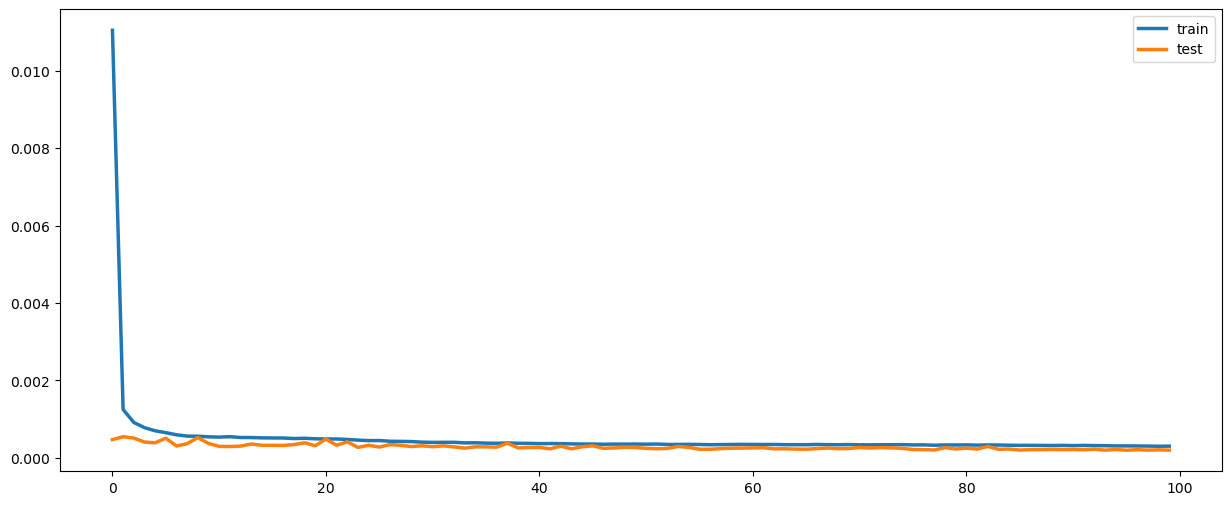

In [158]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [159]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 934us/step


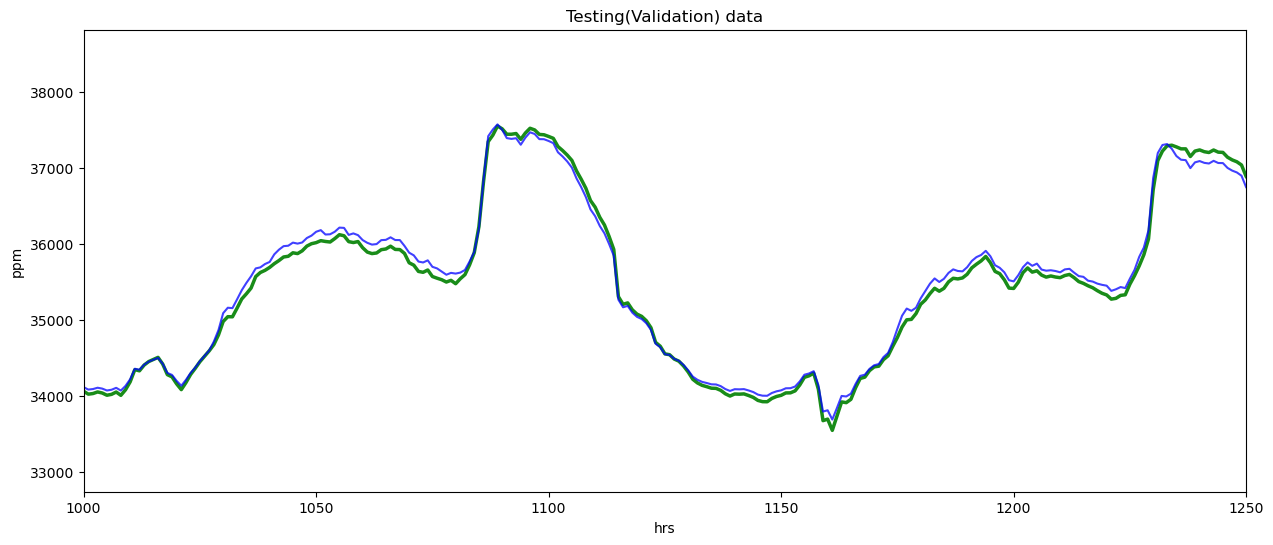

In [160]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [161]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 112.374016
MAPE: 0.2674299757927656 %


# Giữ vị trí dropout như trên và epochs = 150

In [162]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 7s - loss: 0.0118 - val_loss: 5.2855e-04 - 7s/epoch - 6ms/step
Epoch 2/100
1119/1119 - 3s - loss: 0.0014 - val_loss: 4.8696e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1119/1119 - 3s - loss: 9.0940e-04 - val_loss: 4.4751e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1119/1119 - 3s - loss: 7.7033e-04 - val_loss: 4.0193e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1119/1119 - 3s - loss: 6.7932e-04 - val_loss: 3.9523e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1119/1119 - 3s - loss: 6.0673e-04 - val_loss: 3.2603e-04 - 3s/epoch - 3ms/step
Epoch 7/100
1119/1119 - 3s - loss: 5.7510e-04 - val_loss: 2.7640e-04 - 3s/epoch - 3ms/step
Epoch 8/100
1119/1119 - 3s - loss: 5.5116e-04 - val_loss: 2.7875e-04 - 3s/epoch - 3ms/step
Epoch 9/100
1119/1119 - 3s - loss: 5.3880e-04 - val_loss: 2.9318e-04 - 3s/epoch - 3ms/step
Epoch 10/100
1119/1119 - 3s - loss: 5.2399e-04 - val_loss: 2.9171e-04 - 3s/epoch - 3ms/step
Epoch 11/100
1119/1119 - 3s - loss: 5.2271e-04 - val_loss: 3.0483e-04 - 3s/epoch - 3ms/step
Epoch

Epoch 91/100
1119/1119 - 3s - loss: 3.1318e-04 - val_loss: 1.9486e-04 - 3s/epoch - 3ms/step
Epoch 92/100
1119/1119 - 3s - loss: 3.1544e-04 - val_loss: 2.8147e-04 - 3s/epoch - 3ms/step
Epoch 93/100
1119/1119 - 3s - loss: 3.1474e-04 - val_loss: 2.1953e-04 - 3s/epoch - 3ms/step
Epoch 94/100
1119/1119 - 3s - loss: 3.1387e-04 - val_loss: 2.2832e-04 - 3s/epoch - 3ms/step
Epoch 95/100
1119/1119 - 3s - loss: 3.0986e-04 - val_loss: 2.0899e-04 - 3s/epoch - 3ms/step
Epoch 96/100
1119/1119 - 3s - loss: 3.0682e-04 - val_loss: 2.0337e-04 - 3s/epoch - 3ms/step
Epoch 97/100
1119/1119 - 3s - loss: 3.0699e-04 - val_loss: 2.3823e-04 - 3s/epoch - 3ms/step
Epoch 98/100
1119/1119 - 3s - loss: 3.0814e-04 - val_loss: 1.9440e-04 - 3s/epoch - 3ms/step
Epoch 99/100
1119/1119 - 3s - loss: 2.9901e-04 - val_loss: 2.0253e-04 - 3s/epoch - 3ms/step
Epoch 100/100
1119/1119 - 3s - loss: 3.0220e-04 - val_loss: 1.9298e-04 - 3s/epoch - 3ms/step


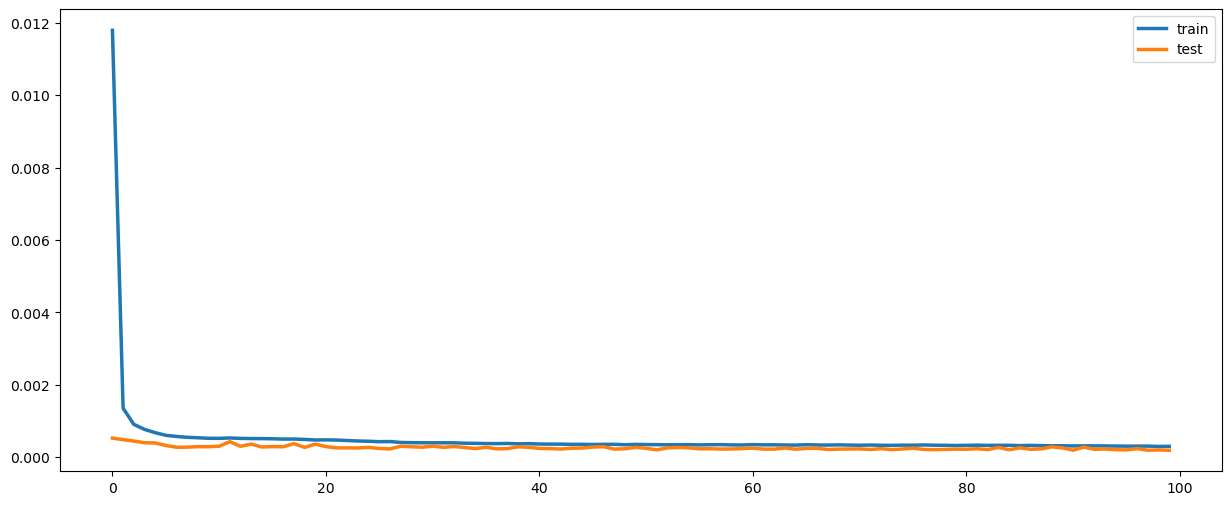

In [163]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [164]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 1ms/step


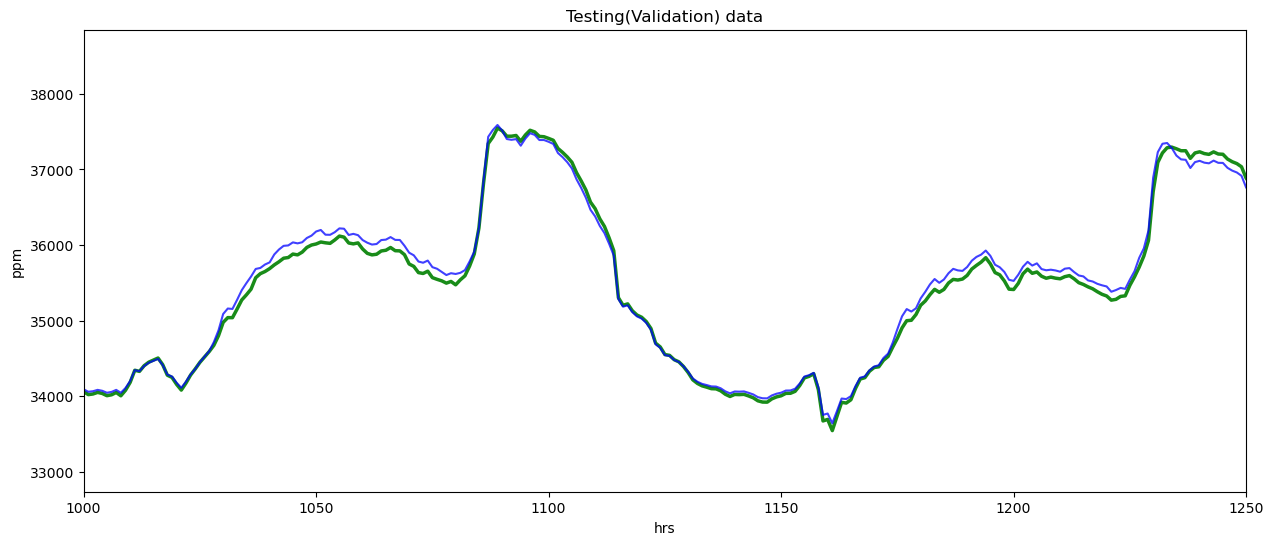

In [165]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [166]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 115.42667
MAPE: 0.25632395409047604 %


# Giữ vị trí dropout như trên và epochs = 500

In [167]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(30))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 6s - loss: 0.0113 - val_loss: 4.8145e-04 - 6s/epoch - 5ms/step
Epoch 2/500
1119/1119 - 3s - loss: 0.0013 - val_loss: 5.9633e-04 - 3s/epoch - 3ms/step
Epoch 3/500
1119/1119 - 3s - loss: 8.9792e-04 - val_loss: 4.3379e-04 - 3s/epoch - 3ms/step
Epoch 4/500
1119/1119 - 3s - loss: 7.6800e-04 - val_loss: 4.8366e-04 - 3s/epoch - 3ms/step
Epoch 5/500
1119/1119 - 3s - loss: 6.7705e-04 - val_loss: 3.5048e-04 - 3s/epoch - 3ms/step
Epoch 6/500
1119/1119 - 3s - loss: 6.1975e-04 - val_loss: 3.6264e-04 - 3s/epoch - 3ms/step
Epoch 7/500
1119/1119 - 3s - loss: 5.8668e-04 - val_loss: 3.0593e-04 - 3s/epoch - 3ms/step
Epoch 8/500
1119/1119 - 3s - loss: 5.6500e-04 - val_loss: 3.3004e-04 - 3s/epoch - 3ms/step
Epoch 9/500
1119/1119 - 3s - loss: 5.3979e-04 - val_loss: 2.9884e-04 - 3s/epoch - 3ms/step
Epoch 10/500
1119/1119 - 3s - loss: 5.3136e-04 - val_loss: 2.9494e-04 - 3s/epoch - 3ms/step
Epoch 11/500
1119/1119 - 3s - loss: 5.2989e-04 - val_loss: 2.9529e-04 - 3s/epoch - 3ms/step
Epoch

Epoch 91/500
1119/1119 - 3s - loss: 3.2386e-04 - val_loss: 2.0772e-04 - 3s/epoch - 3ms/step
Epoch 92/500
1119/1119 - 3s - loss: 3.1824e-04 - val_loss: 2.2323e-04 - 3s/epoch - 3ms/step
Epoch 93/500
1119/1119 - 3s - loss: 3.2320e-04 - val_loss: 2.4735e-04 - 3s/epoch - 3ms/step
Epoch 94/500
1119/1119 - 3s - loss: 3.1704e-04 - val_loss: 2.2359e-04 - 3s/epoch - 3ms/step
Epoch 95/500
1119/1119 - 3s - loss: 3.1800e-04 - val_loss: 2.1762e-04 - 3s/epoch - 3ms/step
Epoch 96/500
1119/1119 - 3s - loss: 3.1460e-04 - val_loss: 2.1696e-04 - 3s/epoch - 3ms/step
Epoch 97/500
1119/1119 - 3s - loss: 3.1138e-04 - val_loss: 1.9796e-04 - 3s/epoch - 3ms/step
Epoch 98/500
1119/1119 - 3s - loss: 3.0834e-04 - val_loss: 2.6657e-04 - 3s/epoch - 3ms/step
Epoch 99/500
1119/1119 - 3s - loss: 3.0793e-04 - val_loss: 2.0770e-04 - 3s/epoch - 3ms/step
Epoch 100/500
1119/1119 - 3s - loss: 3.0273e-04 - val_loss: 1.9390e-04 - 3s/epoch - 3ms/step
Epoch 101/500
1119/1119 - 3s - loss: 3.0712e-04 - val_loss: 2.1272e-04 - 3s/epo

Epoch 180/500
1119/1119 - 3s - loss: 2.6310e-04 - val_loss: 1.7534e-04 - 3s/epoch - 3ms/step
Epoch 181/500
1119/1119 - 3s - loss: 2.6174e-04 - val_loss: 1.7011e-04 - 3s/epoch - 3ms/step
Epoch 182/500
1119/1119 - 3s - loss: 2.5649e-04 - val_loss: 1.7943e-04 - 3s/epoch - 3ms/step
Epoch 183/500
1119/1119 - 3s - loss: 2.5496e-04 - val_loss: 1.6781e-04 - 3s/epoch - 3ms/step
Epoch 184/500
1119/1119 - 3s - loss: 2.6168e-04 - val_loss: 1.7693e-04 - 3s/epoch - 3ms/step
Epoch 185/500
1119/1119 - 3s - loss: 2.5526e-04 - val_loss: 1.7120e-04 - 3s/epoch - 3ms/step
Epoch 186/500
1119/1119 - 3s - loss: 2.5842e-04 - val_loss: 1.6909e-04 - 3s/epoch - 3ms/step
Epoch 187/500
1119/1119 - 3s - loss: 2.5523e-04 - val_loss: 1.7380e-04 - 3s/epoch - 3ms/step
Epoch 188/500
1119/1119 - 3s - loss: 2.5455e-04 - val_loss: 1.7880e-04 - 3s/epoch - 3ms/step
Epoch 189/500
1119/1119 - 3s - loss: 2.5855e-04 - val_loss: 1.7129e-04 - 3s/epoch - 3ms/step
Epoch 190/500
1119/1119 - 3s - loss: 2.5696e-04 - val_loss: 1.7600e-04

1119/1119 - 3s - loss: 2.3479e-04 - val_loss: 1.6271e-04 - 3s/epoch - 3ms/step
Epoch 269/500
1119/1119 - 3s - loss: 2.3829e-04 - val_loss: 1.6978e-04 - 3s/epoch - 3ms/step
Epoch 270/500
1119/1119 - 3s - loss: 2.3619e-04 - val_loss: 1.7154e-04 - 3s/epoch - 3ms/step
Epoch 271/500
1119/1119 - 3s - loss: 2.4049e-04 - val_loss: 1.6557e-04 - 3s/epoch - 3ms/step
Epoch 272/500
1119/1119 - 3s - loss: 2.3498e-04 - val_loss: 1.6316e-04 - 3s/epoch - 3ms/step
Epoch 273/500
1119/1119 - 3s - loss: 2.3356e-04 - val_loss: 1.6325e-04 - 3s/epoch - 3ms/step
Epoch 274/500
1119/1119 - 3s - loss: 2.3427e-04 - val_loss: 1.7196e-04 - 3s/epoch - 3ms/step
Epoch 275/500
1119/1119 - 3s - loss: 2.3529e-04 - val_loss: 1.6839e-04 - 3s/epoch - 3ms/step
Epoch 276/500
1119/1119 - 3s - loss: 2.3647e-04 - val_loss: 1.6835e-04 - 3s/epoch - 3ms/step
Epoch 277/500
1119/1119 - 3s - loss: 2.3732e-04 - val_loss: 1.6402e-04 - 3s/epoch - 3ms/step
Epoch 278/500
1119/1119 - 3s - loss: 2.3496e-04 - val_loss: 1.6749e-04 - 3s/epoch - 

Epoch 357/500
1119/1119 - 3s - loss: 2.2269e-04 - val_loss: 1.7215e-04 - 3s/epoch - 3ms/step
Epoch 358/500
1119/1119 - 3s - loss: 2.2410e-04 - val_loss: 1.7229e-04 - 3s/epoch - 3ms/step
Epoch 359/500
1119/1119 - 3s - loss: 2.2226e-04 - val_loss: 1.6723e-04 - 3s/epoch - 3ms/step
Epoch 360/500
1119/1119 - 3s - loss: 2.2295e-04 - val_loss: 1.6732e-04 - 3s/epoch - 3ms/step
Epoch 361/500
1119/1119 - 3s - loss: 2.1919e-04 - val_loss: 1.7002e-04 - 3s/epoch - 3ms/step
Epoch 362/500
1119/1119 - 3s - loss: 2.2213e-04 - val_loss: 1.7329e-04 - 3s/epoch - 3ms/step
Epoch 363/500
1119/1119 - 3s - loss: 2.1822e-04 - val_loss: 1.6705e-04 - 3s/epoch - 3ms/step
Epoch 364/500
1119/1119 - 3s - loss: 2.1933e-04 - val_loss: 1.7346e-04 - 3s/epoch - 3ms/step
Epoch 365/500
1119/1119 - 3s - loss: 2.1919e-04 - val_loss: 1.6854e-04 - 3s/epoch - 3ms/step
Epoch 366/500
1119/1119 - 3s - loss: 2.1799e-04 - val_loss: 1.7603e-04 - 3s/epoch - 3ms/step
Epoch 367/500
1119/1119 - 3s - loss: 2.2026e-04 - val_loss: 1.7400e-04

1119/1119 - 3s - loss: 2.0496e-04 - val_loss: 9.0309e-04 - 3s/epoch - 3ms/step
Epoch 446/500
1119/1119 - 3s - loss: 2.0380e-04 - val_loss: 9.6478e-04 - 3s/epoch - 3ms/step
Epoch 447/500
1119/1119 - 3s - loss: 2.0503e-04 - val_loss: 9.0989e-04 - 3s/epoch - 3ms/step
Epoch 448/500
1119/1119 - 3s - loss: 2.0325e-04 - val_loss: 0.0010 - 3s/epoch - 3ms/step
Epoch 449/500
1119/1119 - 3s - loss: 2.0270e-04 - val_loss: 0.0011 - 3s/epoch - 3ms/step
Epoch 450/500
1119/1119 - 3s - loss: 2.0278e-04 - val_loss: 0.0011 - 3s/epoch - 3ms/step
Epoch 451/500
1119/1119 - 3s - loss: 2.0047e-04 - val_loss: 0.0012 - 3s/epoch - 3ms/step
Epoch 452/500
1119/1119 - 3s - loss: 2.0061e-04 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 453/500
1119/1119 - 3s - loss: 2.0051e-04 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 454/500
1119/1119 - 3s - loss: 2.0137e-04 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 455/500
1119/1119 - 3s - loss: 2.0050e-04 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 456/500
1119/1119

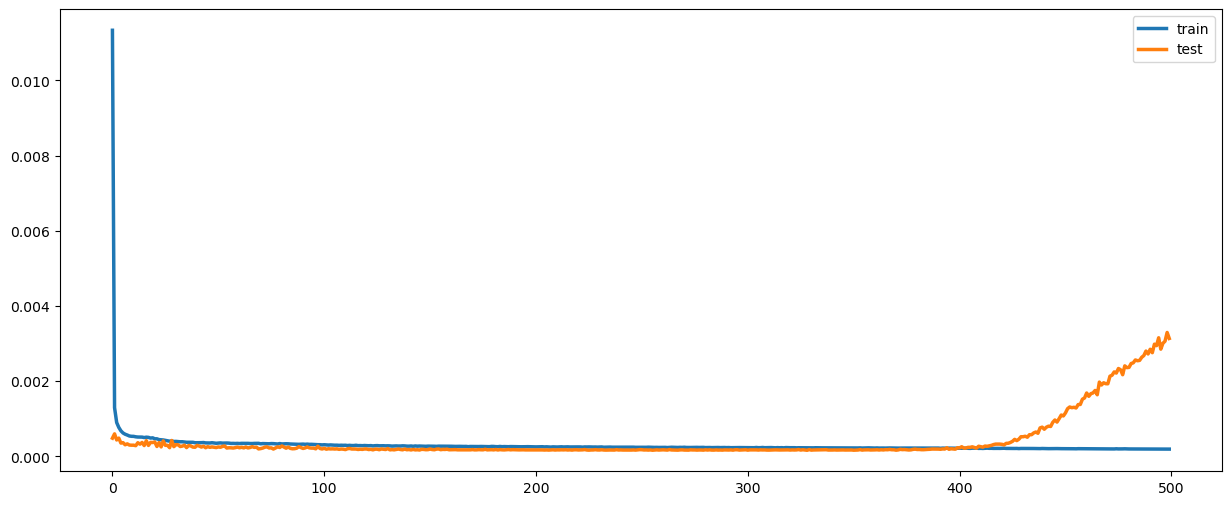

In [168]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [169]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 1ms/step


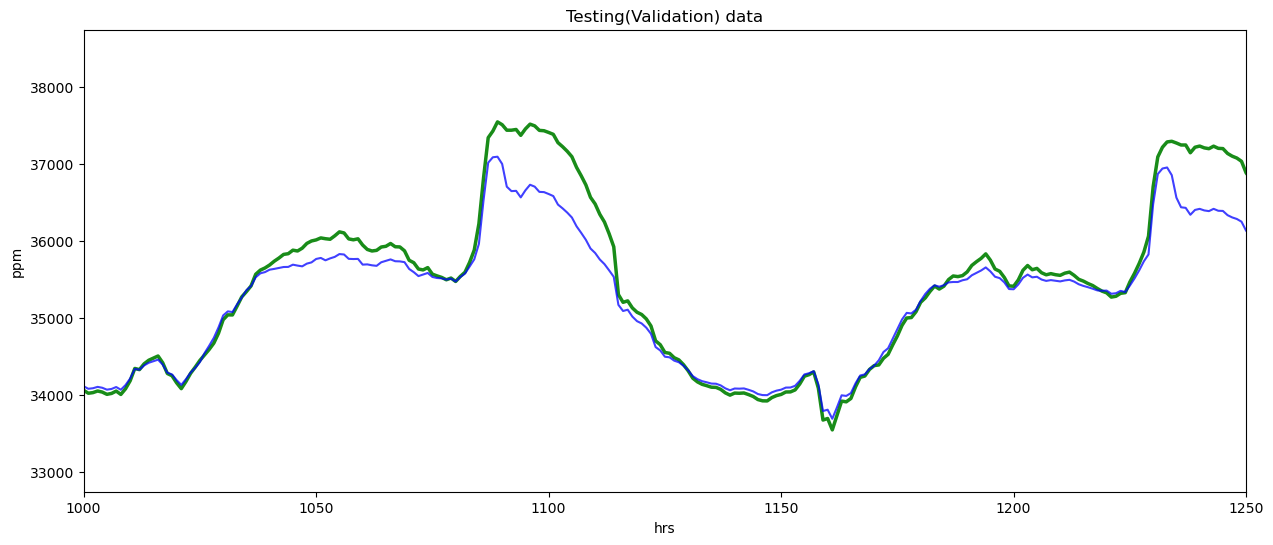

In [170]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [171]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 322.52057
MAPE: 0.5822507664561272 %


In [ ]:
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))